# Figure 10: Sub-unit responses and detailed look at model properties

In [7]:
from setup_nb import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from detector.implementations import TwoQ, FourQ
from detector.stimulus import FastDiscretePhi

### Simulations

#### Parameters

In [305]:
dt = 0.001  # in s

lam = 90.0
duration = 10.0
start = 0.5
stop = 9.5

contrast = 0.25
offset = 1.3

recfield = 240.0
delta_phi = 4.0

param_velo = np.logspace(0, 3, base=10, num=20)  # in deg/s

param_offsets = np.linspace(2, 5, num=10)
param_contrasts = np.linspace(0, 2, num=15)

param_dc = np.arange(-10, 11) * 0.025

#### Detectors

In [10]:
tau_hp = 0.25
tau_lp = 0.05

d_2q_dc = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp), dc=(0.1, 0.1), dt=dt)

d_t4 = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp), dc=(0.1, 0.1), pathway_weights=(1.0, 0.0), dt=dt)
d_t5 = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp), dc=(0.1, 0.1), pathway_weights=(0.0, 1.0), dt=dt)

d_4q = FourQ(tau_hp=tau_hp, tau_lp=tau_lp, dc=0.0, dt=dt)

#### Run

In [11]:
def run(detector, flip, lam=90.0):
        
    sys.stdout.write("\n"); sys.stdout.flush()
    
    c = []
    for velo in param_velo:
        stim = FastDiscretePhi(lam=lam, duration=duration, start=start, stop=stop, nd=False,
                               flip=flip, vel=velo).render(recfield, delta_phi, dt)
        stim = np.maximum(contrast * stim + offset, 0)
        
        output = detector.detect(stim)
        c.append(output.mean())
        sys.stdout.write("."); sys.stdout.flush()
        
    c = np.array(c)
    return np.array(c)

In [201]:
phi_2q_dc = run(d_2q_dc, False)
rphi_2q_dc = run(d_2q_dc, True)

phi_4q = run(d_4q, False)
rphi_4q = run(d_4q, True)

phi_t4 = run(d_t4, False)
rphi_t4 = run(d_t4, True)

phi_t5 = run(d_t5, False)
rphi_t5 = run(d_t5, True)


....................
....................
....................
....................
....................
....................
....................
....................

In [68]:
def run_stim_matrix_dc(dcs, velos, pathway_weights, flip=True):
    
    sys.stdout.write("\n"); sys.stdout.flush()
    
    output = np.zeros((dcs.shape[0], velos.shape[0]))
    
    for idx1, dc in enumerate(dcs):
        for idx2, vel in enumerate(velos):
            
            d = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp),
                     dc=(dc, dc), pathway_weights=pathway_weights, dt=dt)

            stim = FastDiscretePhi(lam=lam, duration=duration, start=start, stop=stop, nd=False,
                                       flip=flip, vel=vel).render(recfield, delta_phi, dt)
            stim = np.maximum(contrast * stim + offset, 0)
            
            output[idx1, idx2] = d.detect(stim).mean()
            sys.stdout.write("."); sys.stdout.flush()
            
    return output / np.abs(output).max()

In [259]:
mat_t4_dc = run_stim_matrix_dc(param_dc, param_velo, (1.0, 0.0), flip=True)
mat_t5_dc = run_stim_matrix_dc(param_dc, param_velo, (0.0, 1.0), flip=True)


....................................................................................................................................................................................................................................................................................................................................................................................................................................
....................................................................................................................................................................................................................................................................................................................................................................................................................................

### Panels

In [364]:
def panel_dc_map(rmap, ax, clip=0.2, cax=None, annot=False):
    
    dc_step = np.diff(param_dc)[0] * 50

    pc = ax.matshow(rmap, origin="lower", cmap="PRGn", vmin=-clip, vmax=clip, rasterized=True)
    
    ax.set_ylabel("DC contribution (%)", labelpad=2.0)
    ax.set_xlabel(u"Pattern speed (°/s)", labelpad=2.0)
    
    xticks = np.log(np.array([1, 10, 100, 1000]))
    xticks = 19 * xticks / xticks.max()
    ax.set_xticks(xticks)
    ax.set_xticklabels(["$\mathregular{10^" + str(x) + "}$" for x in range(4)])
    
    ax.set_yticks([2, 6, 10, 14, 18])
    ax.set_yticklabels([-20, -10, 0, 10, 20])
    
    ax.tick_params(axis='both', which='major', pad=2)
    sb.plt.minorticks_off()

    l = ax.plot(ax.get_xlim(), [10, 10], linestyle="dotted", zorder=1000, color="#444444")
    l[0].set_dashes([1, 1])
    
    if annot:
        ax.annotate("",
                    xy=(-0.5, 14), xycoords='data',
                    xytext=(5, 14), textcoords='data',
                    arrowprops=dict(arrowstyle="-|>", linewidth=1.0, facecolor="black"))
    
    if cax:
        cb = sb.plt.colorbar(pc, cax=cax)
        cb.set_label("Normalized\nresponse (a.u.)", labelpad=-9)
        cb.set_ticks([-clip, 0, clip])
        cb.set_ticklabels(["< {0}".format(-clip), "0", "> {0}".format(clip)])
        cax.tick_params(axis='both', which='major', pad=2)
    
    sb.despine(ax=ax)

In [20]:
def panel_summary_t4t5(tuning1, tuning2, ax, legend=False):
    
    m = np.max([np.abs(tuning1).max(), np.abs(tuning2).max()])
    tuning1, tuning2 = tuning1 / m, tuning2 / m
    
    lw = 1.0
    ax.plot(param_velo, tuning1, color=gt_colors["ON"], label="ON", linewidth=lw)
    ax.plot(param_velo, tuning2, color=gt_colors["OFF"], label="OFF", linewidth=lw)
    
    ax.set_xscale('log')
    ax.set_xlim([param_velo[0], param_velo[-1]])
    ax.set_xticks([1, 10, 100, 1000])
    ax.set_ylim([-1.2, 0.7])
    ax.set_yticks([-1.0, -0.5, 0, 0.5])
    ax.set_ylabel("Normalized mean\nresponse (a.u.)", labelpad=2.5)
    ax.set_xlabel(u"Pattern speed (°/s)", labelpad=3.0)
    
    ax.tick_params(axis='both', which='major', pad=2)

    sb.plt.minorticks_off()
    
    if legend:
        ax.legend(loc=(0.0, 0.7))
    
    add_refline(ax, horizontal=True)
    
    sb.despine(ax=ax)

In [363]:
def model_figure():
        
    off = 1.6
    rows = [0, 3.4, 5.8]
    panelsize = (2, 2)
    
    clip = 0.6

    fig = sb.plt.figure(figsize=(4.4, 1.5))

    height = 1.1
    
    ax = addaxis(fig, (off + rows[0], height), panelsize, letter="a", nudge=0.5)
    panel_summary_t4t5(rphi_t4, rphi_t5, ax, legend=True)
    
    ax = addaxis(fig, (off + rows[1], height), panelsize, letter="b", nudge=0.2)
    panel_dc_map(mat_t4_dc, ax, clip=clip, cax=None, annot=True)
    ax.set_title("ON subunit")
    
    ax = addaxis(fig, (off + rows[2], height), panelsize, letter="c", nudge=0.05)
    cax = addaxis(fig, (off + rows[2] + 2.2, height), (0.15, 2), letter="")
    panel_dc_map(mat_t5_dc, ax, clip=clip, cax=cax)
    remove_axis(ax, y=True)
    ax.set_title("OFF subunit")
    
    fig.set_frameon(False)
    fig.savefig("../output/Fig10.tif", format="tiff", dpi=standard_dpi)

### Plot

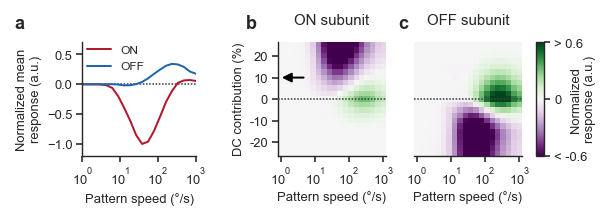

In [362]:
model_figure()